In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import scipy.ndimage as ndi

def mask_correction(mask):
    """Function copied from the Github repository."""
    
    if (len(np.unique(mask)) > 2):
        mask[mask < 128] = 0
        mask[mask >= 128] = 255
        mask = 255-mask
    
    if(len(np.unique(mask)) != 2):
        print('ERROR, CHECK IMAGE MASK')
    
    return mask

img_mask = io.imread('test_image.png')
img_mask = mask_correction(img_mask)
img_mask = 255 - img_mask      # Remove if glands are already white

# Image dilation without merge

<IPython.core.display.Javascript object>


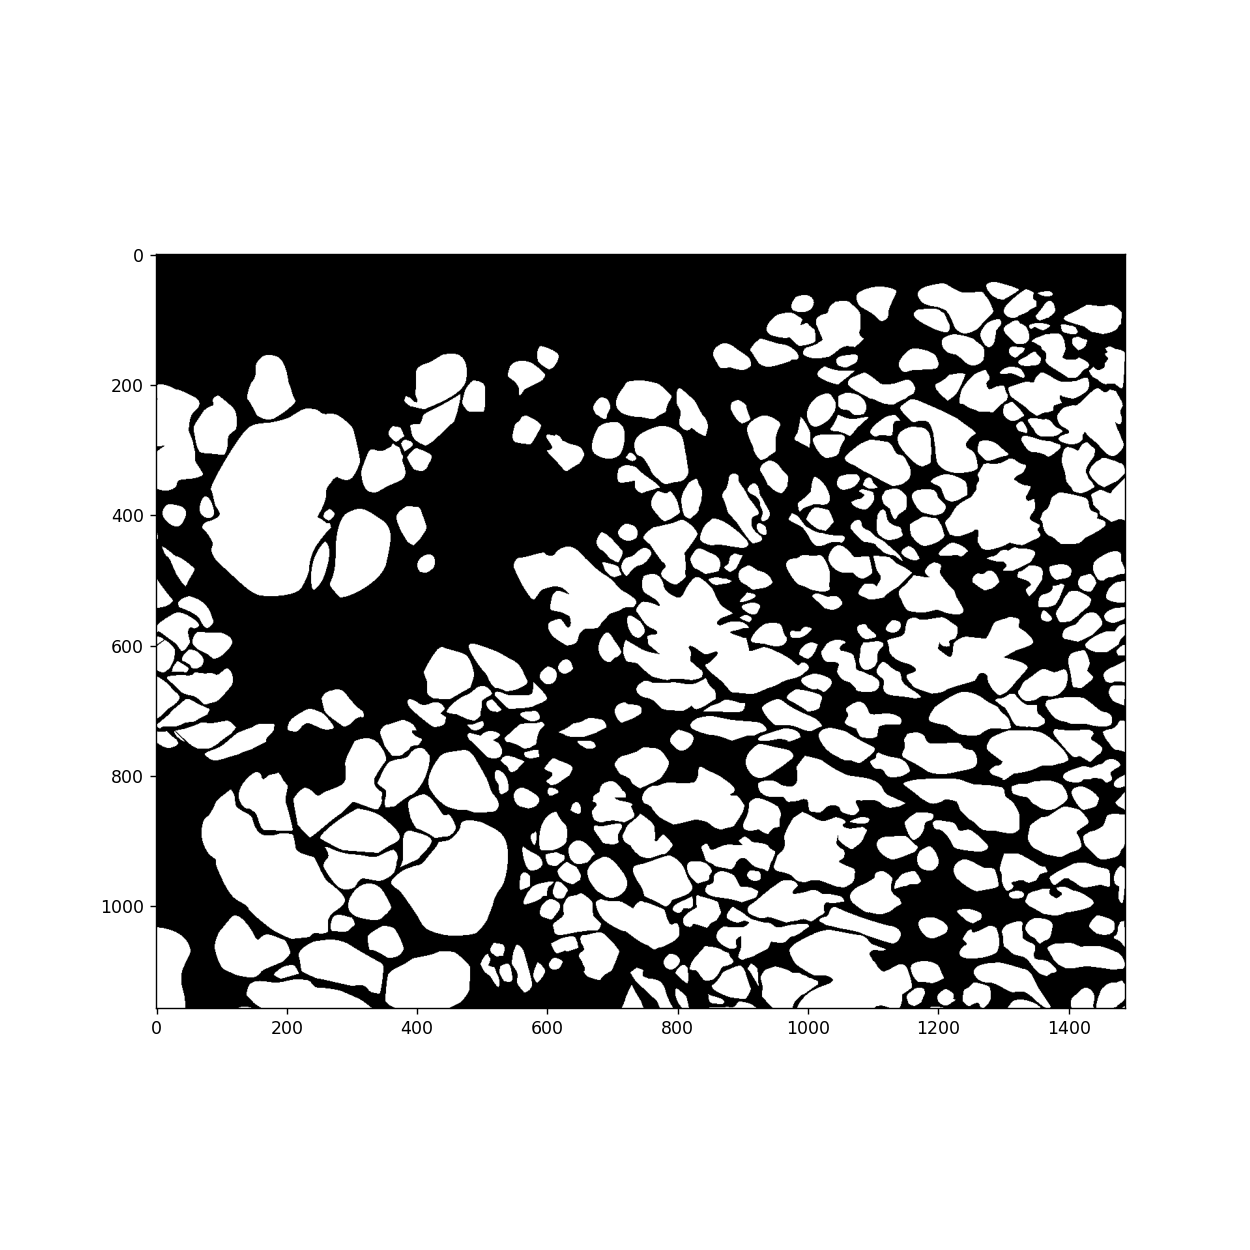

<IPython.core.display.Javascript object>


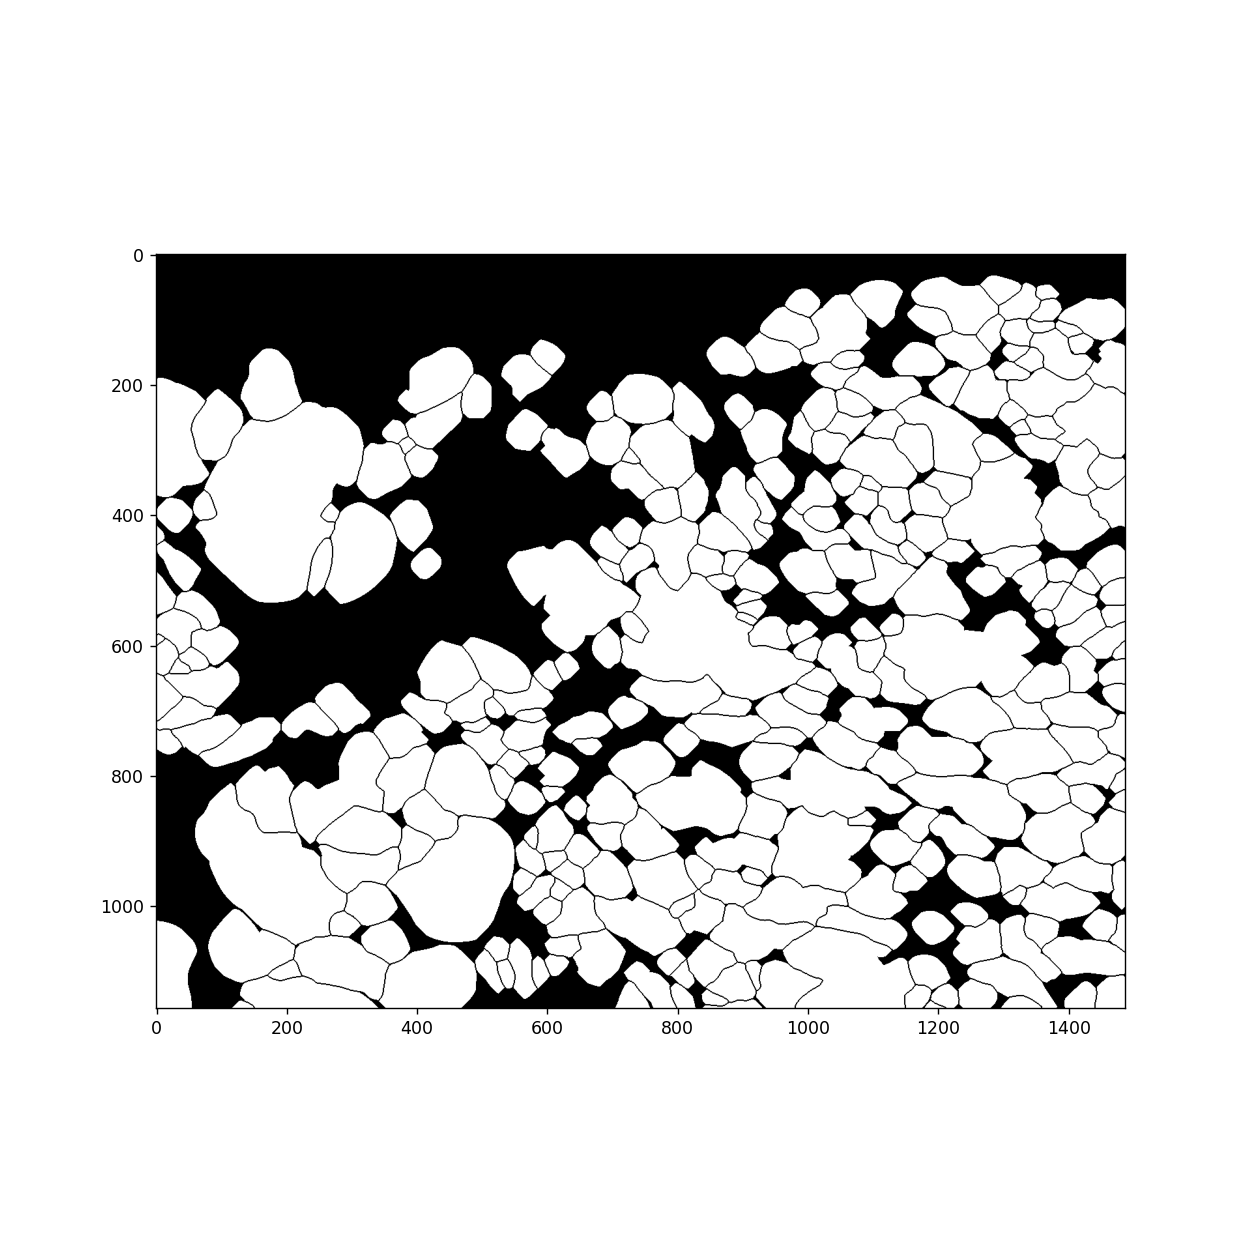

In [3]:
def binary_dilation_no_merge(img_mask, iterations):
    """Dilates image avoiding merging of objects. img_mask must have value 255 for 
    glands and 0 for background."""
    
    img_dist, closest_indices = ndi.distance_transform_edt(255-img_mask, return_distances=True, return_indices=True)
    img_label, num_comp = ndi.label(img_mask, np.ones((3, 3)))
    img_cells = img_label[(closest_indices[0].ravel(), closest_indices[1].ravel())].reshape(img_label.shape)
    gradient = img_der = np.gradient(img_cells)
    img_limits = np.maximum(np.abs(gradient[0]), np.abs(gradient[1]))>0

    structure = [[0, 1, 0],[1, 1, 1],[0, 1, 0]]
    img_mask_dil = ndi.binary_dilation(img_mask, structure=structure, iterations=iterations)
    img_mask_dil_sep = img_mask_dil*np.logical_not(img_limits)

    img_mask_dil_sep_inv = np.logical_not(img_mask_dil_sep)
    img_label_sep, num_comp = ndi.label(img_mask_dil_sep_inv, np.ones((3, 3)))
    tam_comps = ndi.sum(img_mask_dil_sep_inv, img_label_sep, index=range(0, num_comp))
    larg_comp_idx = np.argmax(tam_comps)
    img_mask_final = 255*np.logical_not(img_label_sep==larg_comp_idx).astype(np.uint8)
    
    return img_mask_final


img_mask_dil = binary_dilation_no_merge(img_mask, iterations=10)

plt.figure(figsize=[10, 10])
plt.imshow(img_mask, 'gray')
plt.figure(figsize=[10, 10])
plt.imshow(img_mask_dil, 'gray')

# Randomly remove some glands

<IPython.core.display.Javascript object>


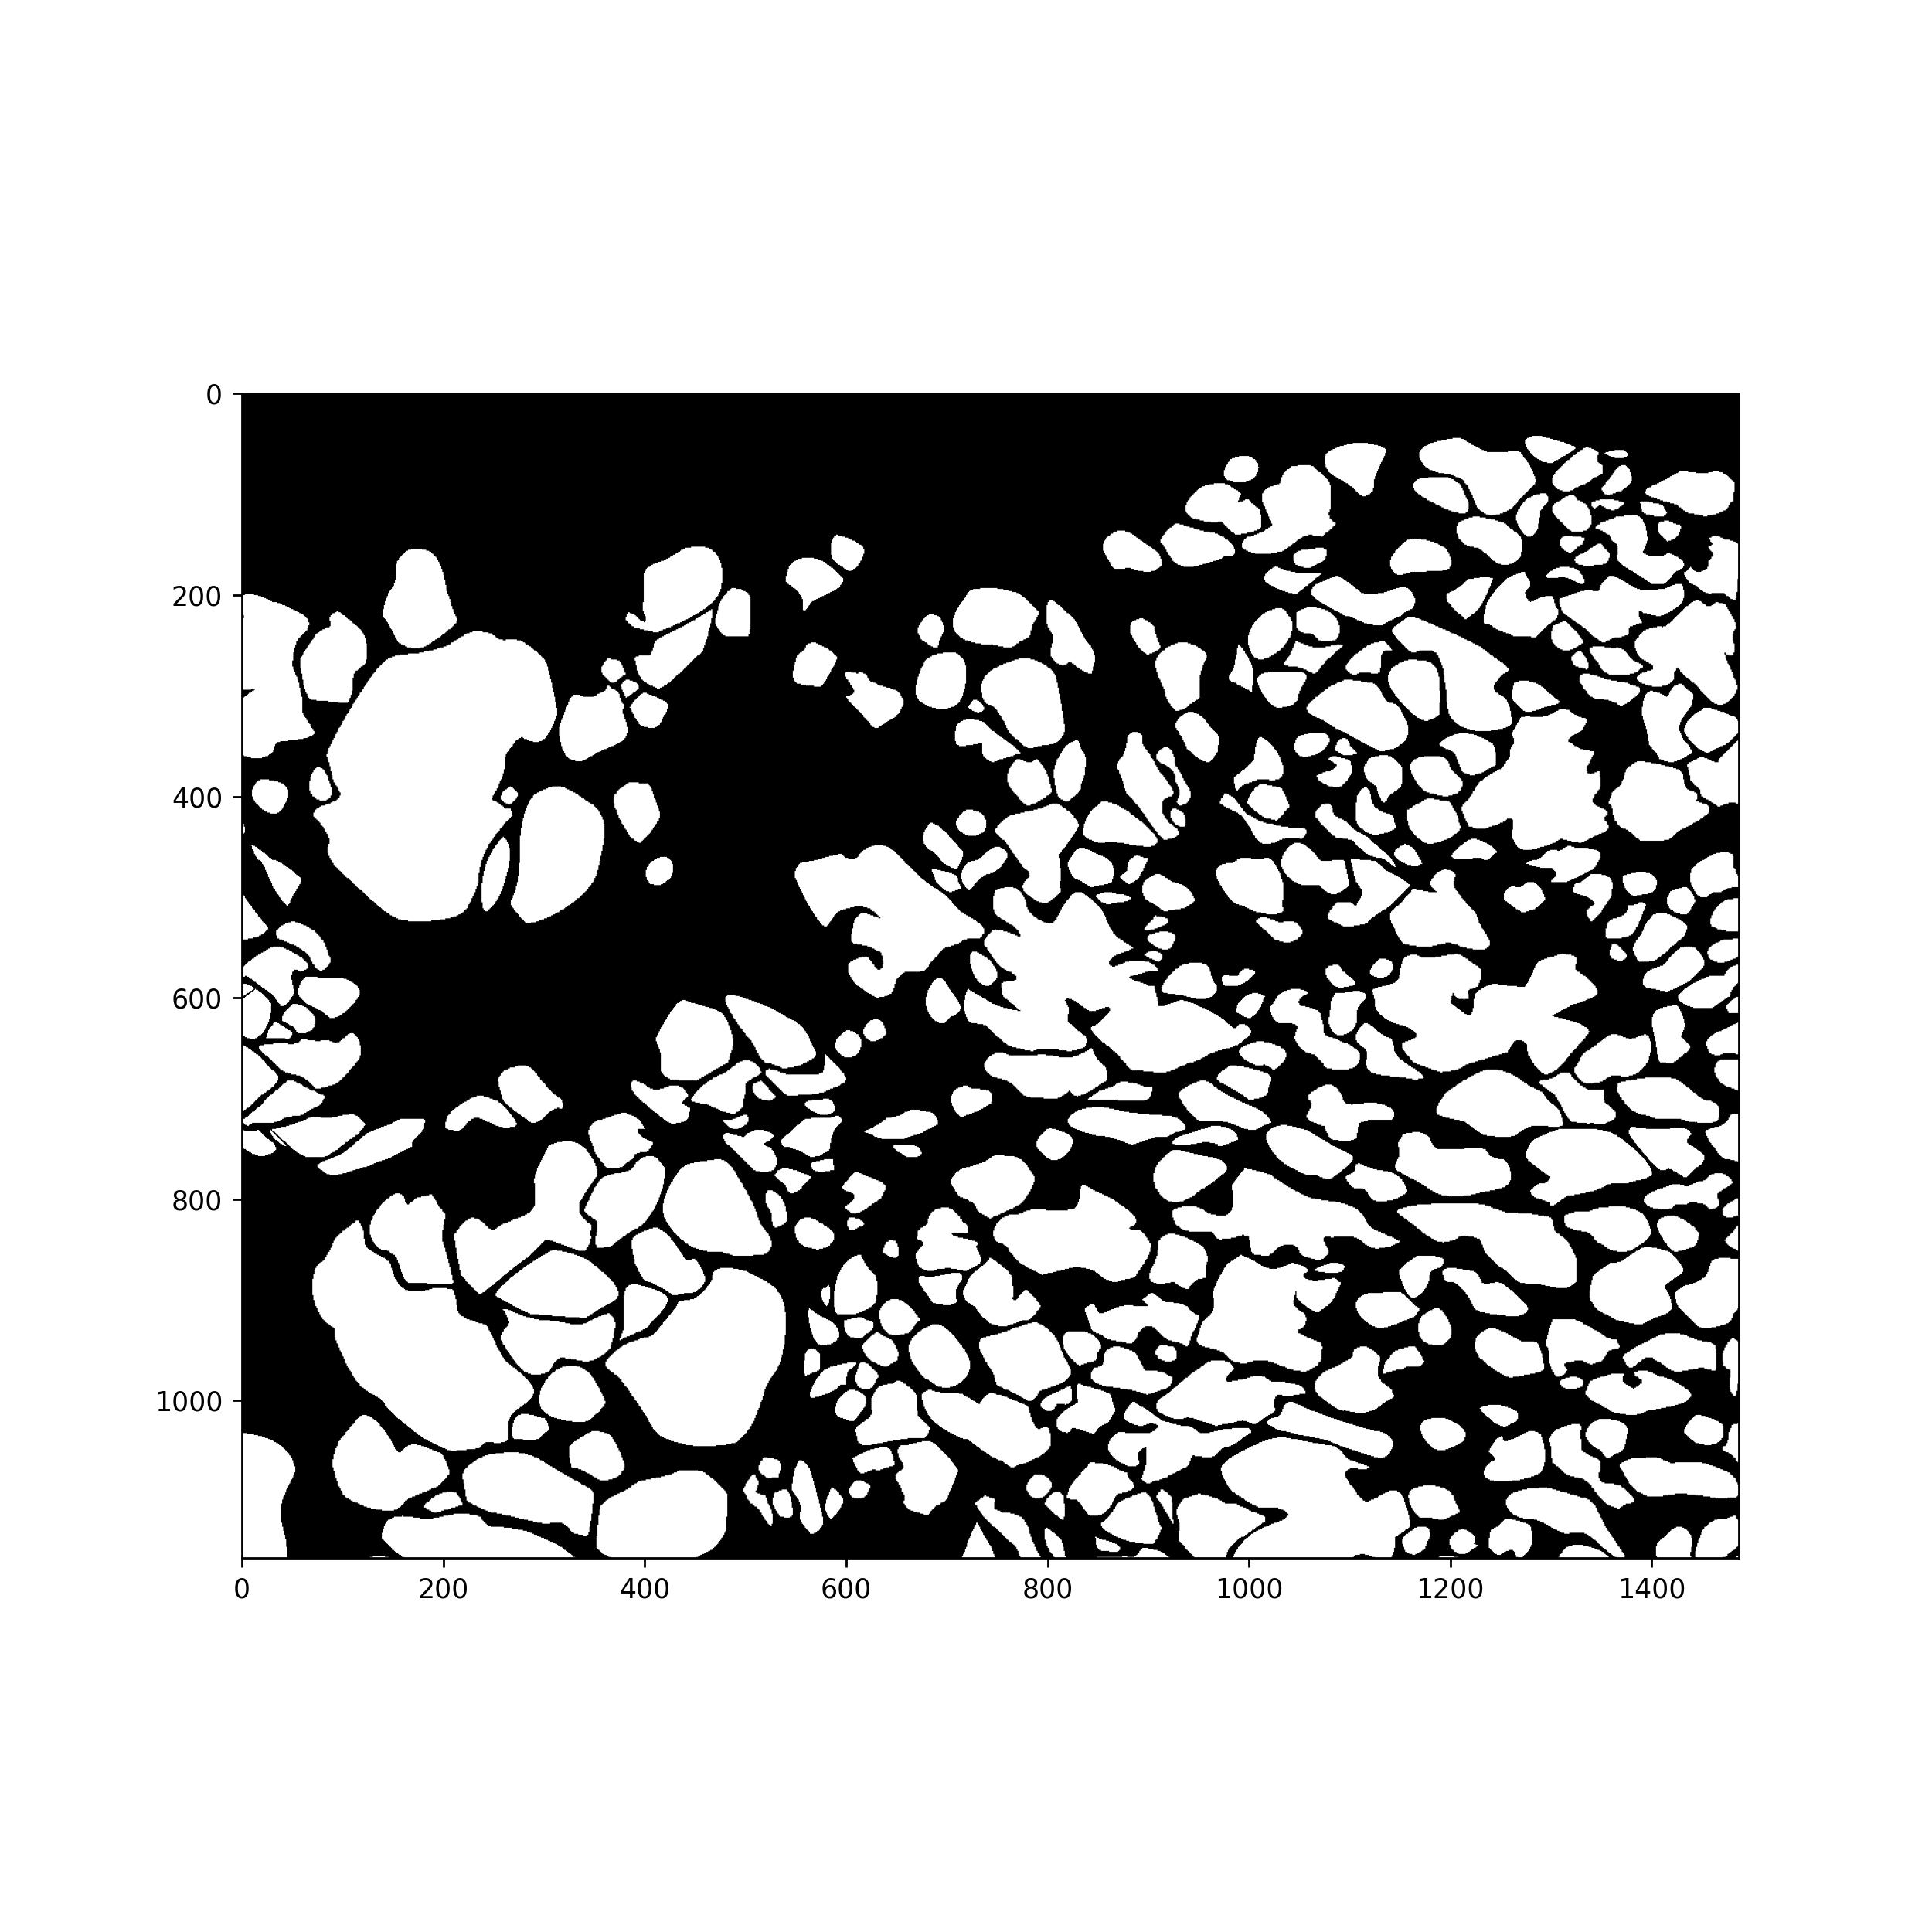

<IPython.core.display.Javascript object>


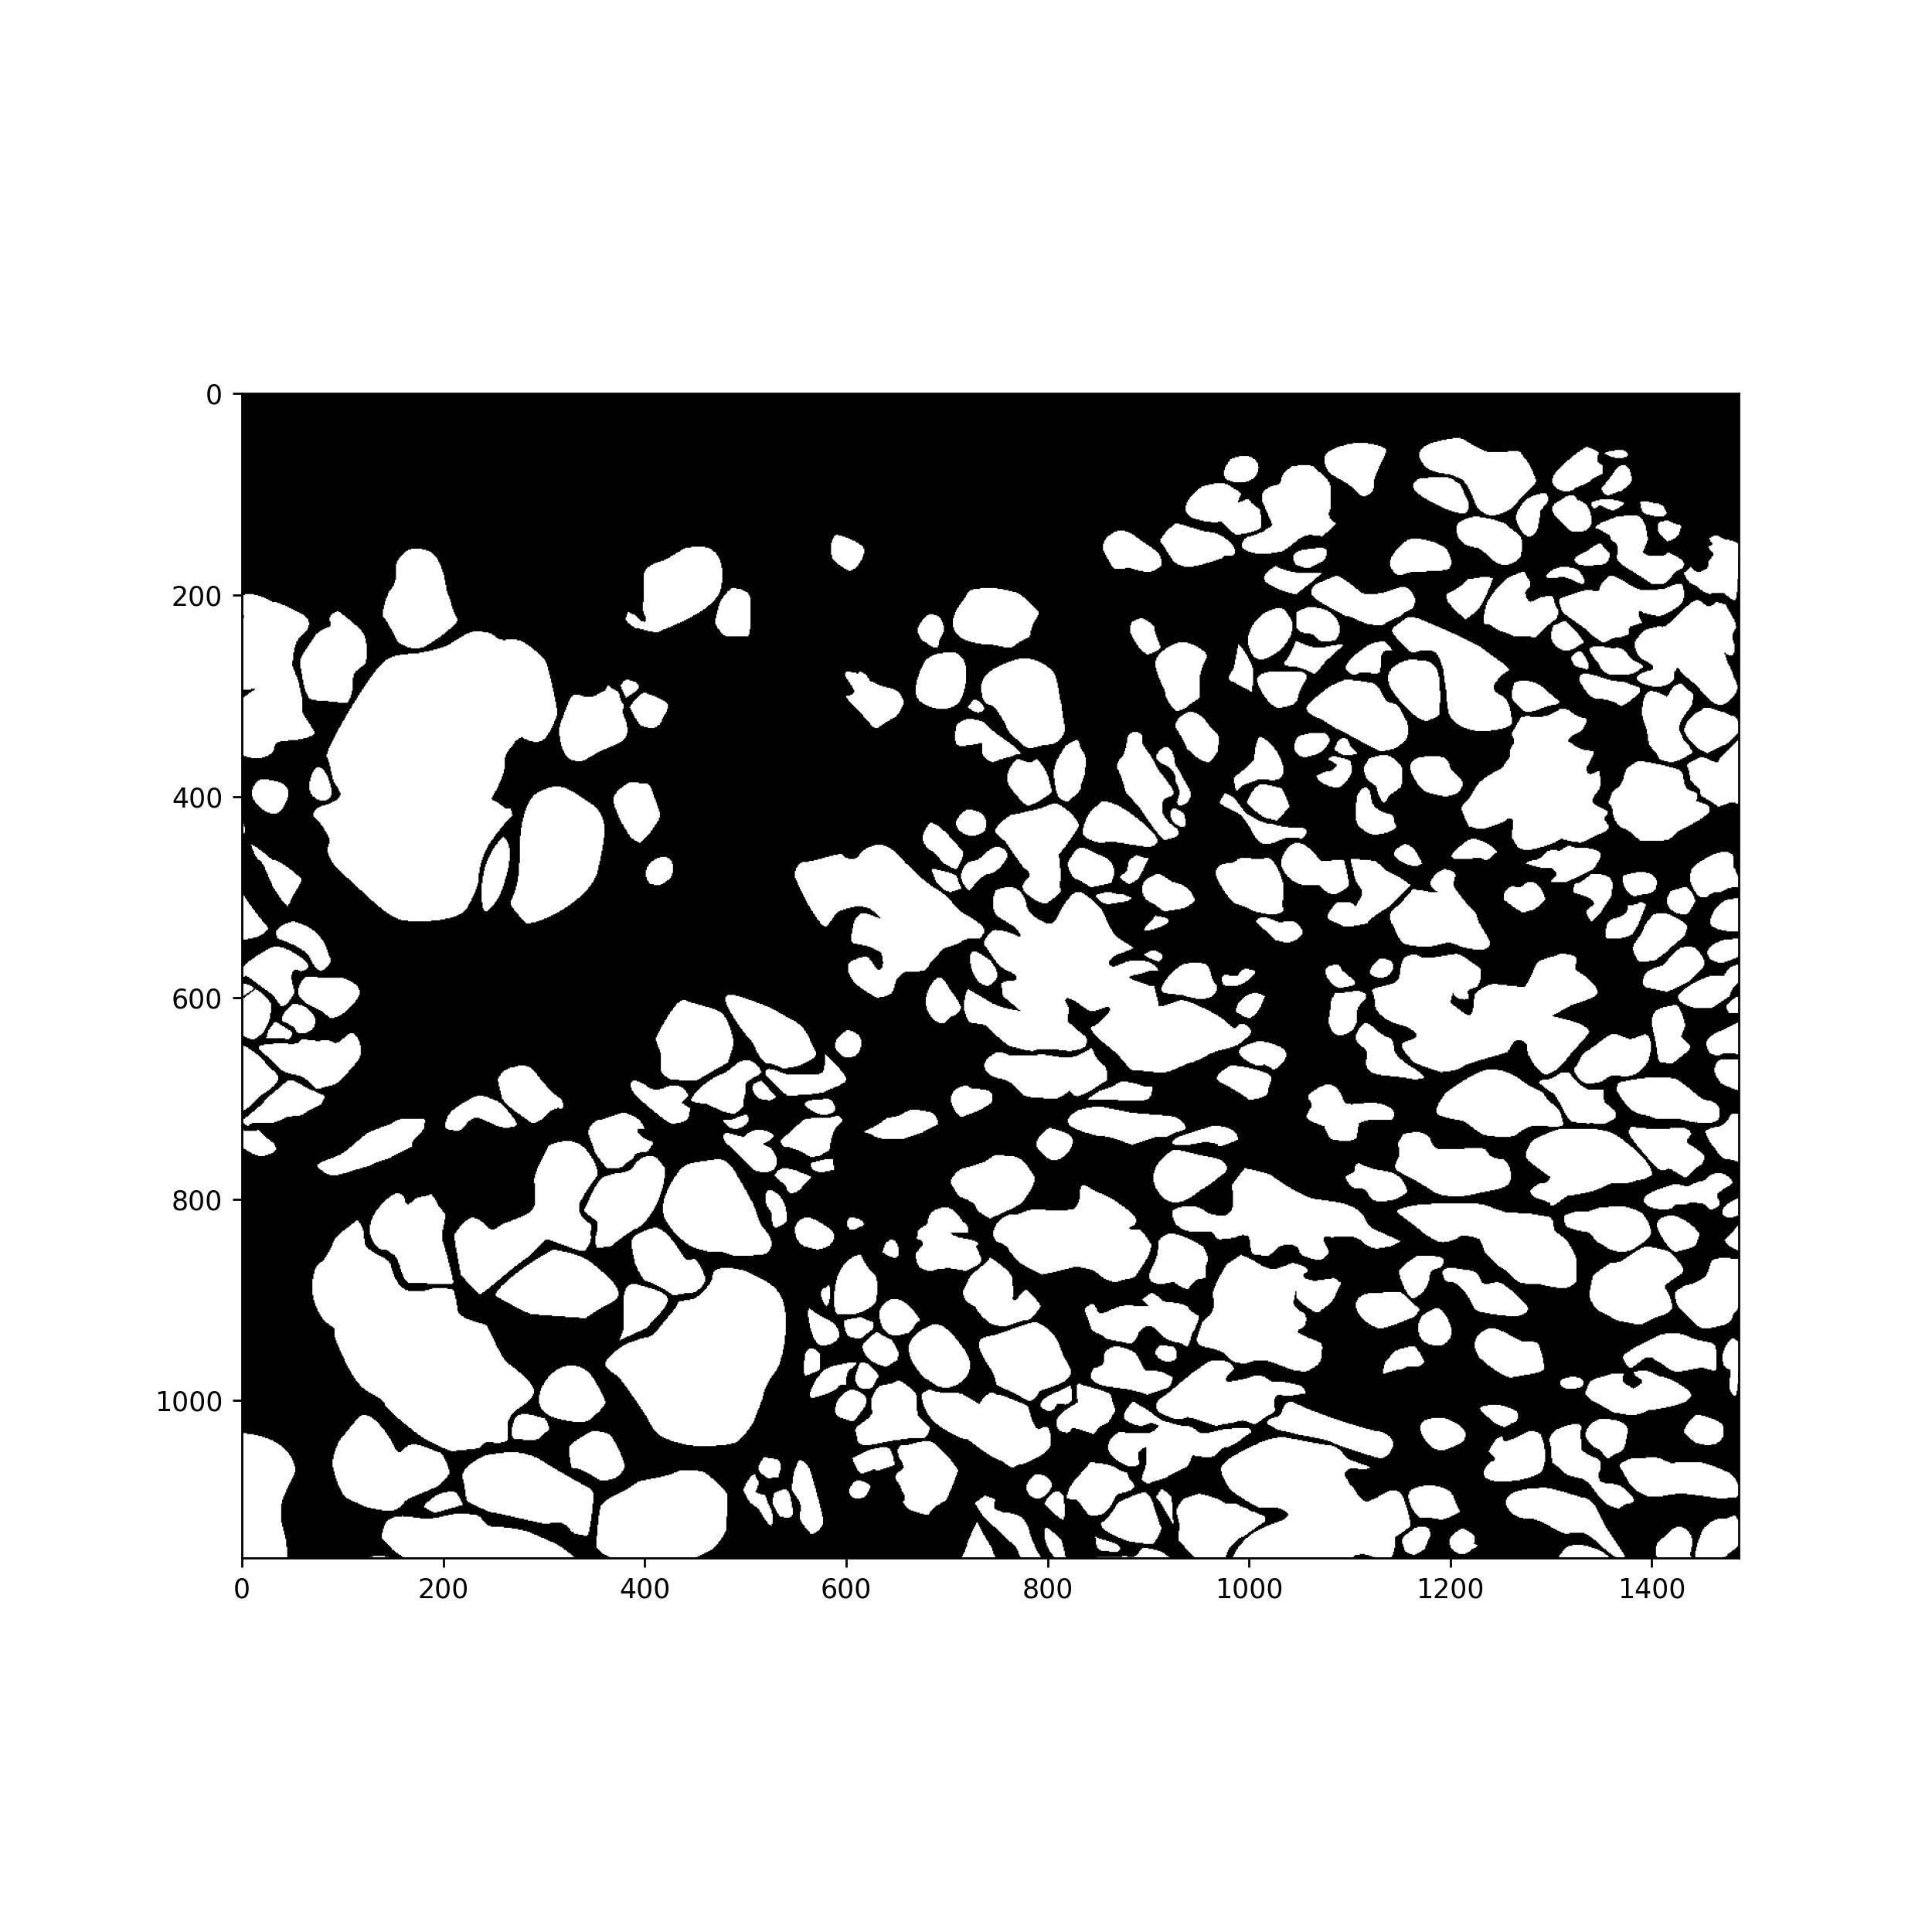

In [5]:
def remove_objects(img_mask, fraction_to_remove):
    """Randomly remove some objects from the image. fraction_to_remove sets the
    fraction of objects that will be remove. fraction_to_remove=0 means that no
    object will be remove. fraction_to_remove=1 removes all objects. img_mask must 
    have value 255 for glands and 0 for background."""

    img_label, num_comp = ndi.label(img_mask, np.ones((3, 3)))
    number_to_remove = int(round(fraction_to_remove*num_comp))
    mask = np.random.permutation([0]*number_to_remove + [1]*(num_comp-number_to_remove))
    mask = np.array([0] + mask.tolist())  # Also remove background

    img_mask_rem_comps = mask[img_label].astype(np.uint8)
    
    return img_mask_rem_comps

fraction_to_remove = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
img_mask_rem = remove_objects(img_mask, fraction_to_remove=0.1)

plt.figure(figsize=[10, 10])
plt.imshow(img_mask, 'gray')
plt.figure(figsize=[10, 10])
plt.imshow(img_mask_rem, 'gray')